## Tsfresh data preparation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
df = pd.read_csv('data/data_processed/client_data.csv')

In [38]:
merged_df = df.copy()

In [ ]:
#drop the columns
merged_df.drop("creation_date", axis=1, inplace=True)

In [ ]:
# Convert invoice_date to datetime
merged_df

,disrict,client_catg,region,target,1transactions_count,consumption_level_1_mean,consumption_level_2_mean,consumption_level_3_mean,consumption_level_4_mean
0,60,11,101,0.0,35,352.400000,10.571429,0.000000,0.000000
1,69,11,107,0.0,37,557.540541,0.000000,0.000000,0.000000
2,62,11,301,0.0,18,798.611111,37.888889,0.000000,0.000000
3,69,11,105,0.0,20,1.200000,0.000000,0.000000,0.000000
4,62,11,303,0.0,14,663.714286,104.857143,117.357143,36.714286
...,...,...,...,...,...,...,...,...,...
135488,62,11,304,0.0,71,1.957746,0.000000,0.000000,0.000000
135489,63,11,311,0.0,41,185.853659,0.756098,0.000000,0.000000
135490,63,11,311,0.0,36,273.083333,0.000000,0.000000,0.000000
135491,60,11,101,0.0,2,300.000000,70.500000,0.000000,0.000000


In [43]:
#defining the target variable and features
target = ['target']
num_features = ['client_id',
                '1transactions_count',
                'consumption_level_1_mean',
                'consumption_level_2_mean',
                'consumption_level_3_mean',
                'consumption_level_4_mean']
cat_features = [col for col in merged_df.columns if col not in num_features and col not in target]

In [44]:
[col for col in merged_df.columns if col not in num_features and col not in target]

['disrict', 'client_catg', 'region']

In [45]:
#preprocessing categorical features
cat_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('one_hot_encoding', OneHotEncoder())
])

In [47]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features),
    #('num', num_pipeline, num_features)
], remainder='passthrough')

In [49]:
df = merged_df.copy()
X = df.drop(columns=["target"], axis=1)  
y = df["target"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# unbalanced dataset?
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [51]:
model_stage1 = XGBClassifier(n_estimators=500, 
                             random_state=42,
                             max_depth=5,        # avoids overfitting
                            learning_rate=0.05, # Slow learning
                            subsample=0.8,      # randomness
                            colsample_bytree=0.8, 
                            scale_pos_weight=scale_pos_weight,  # Adjust based on fraud ratio
                            eval_metric="aucpr") 

In [52]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_stage1) 
])

In [53]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('one_hot_encoding',
                                                                   OneHotEncoder())]),
                                                  ['disrict', 'client_catg',
                                                   'region'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byle...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('one_hot_encoding',
                                                                   OneHotEncoder())]),
                                                  ['disrict', 'client_catg',
                                                   'region'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byle...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [55]:
X_train

,disrict,client_catg,region,1transactions_count,consumption_level_1_mean,consumption_level_2_mean,consumption_level_3_mean,consumption_level_4_mean
52667,63,11,311,73,240.657534,17.780822,2.808219,0.000000
44198,63,11,311,33,46.939394,2.515152,0.000000,0.000000
33454,63,11,311,58,215.275862,27.586207,22.879310,91.086207
47946,60,11,101,33,346.363636,0.060606,0.000000,0.000000
113031,63,11,306,6,323.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
110268,63,11,313,37,505.837838,16.216216,19.189189,18.216216
119879,62,11,301,5,2.400000,0.000000,0.000000,0.000000
103694,69,11,104,4,642.000000,46.500000,0.000000,0.000000
131932,63,11,306,22,313.409091,0.000000,0.000000,0.000000


In [56]:
# Make predictions
y_pred = model_pipeline.predict(X_test)

# Output predictions
print("Predictions:", y_pred)

Predictions: [0 0 0 ... 0 0 0]


In [57]:
X_train.columns

Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consumption_level_1_mean', 'consumption_level_2_mean',
       'consumption_level_3_mean', 'consumption_level_4_mean'],
      dtype='object')

In [58]:
# confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[27004 11330]
 [  809  1505]]
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.82     38334
         1.0       0.12      0.65      0.20      2314

    accuracy                           0.70     40648
   macro avg       0.54      0.68      0.51     40648
weighted avg       0.92      0.70      0.78     40648



In [65]:
# # probabilities for fraud
fraud_probs_stage1 = model_pipeline.predict_proba(X_test)[:, 1]  

# Fraud probabilities for second stage model > 50%
# 1st stage: optimize recall, 2nd stage optimize precision
suspicious_cases = X_test[fraud_probs_stage1 > 0.30] # only use propabilities larger 30% for2nd stage model

# not needed 
y_suspicious = y_test[fraud_probs_stage1 > 0.30] # snot used

In [ ]:
# decision tree for second stage
dt_model_stage2 = LogisticRegression(C=0.1, 
    penalty='l1', 
    solver='liblinear', 
    class_weight='balanced', 
    max_iter=500)
dt_model_stage2.fit(suspicious_cases, y_suspicious)

fraud_probs_stage2 = dt_model_stage2.predict_proba(suspicious_cases)[:, 1]

# categorize risk
def risk_category(prob):
    if prob > 0.7:
        return "High Risk"
    elif prob > 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"

suspicious_cases_output = suspicious_cases.copy()
suspicious_cases_output["Risk Level"] = [risk_category(p) for p in fraud_probs_stage2]


In [67]:
high_risk_cases = suspicious_cases_output#[suspicious_cases_output["Risk Level"] == "High Risk"]
high_risk_cases.head()

,disrict,client_catg,region,1transactions_count,consumption_level_1_mean,consumption_level_2_mean,consumption_level_3_mean,consumption_level_4_mean,Risk Level
134491,60,11,101,26,676.000000,117.076923,8.653846,0.0,Low Risk
92503,63,11,311,82,397.329268,10.439024,0.000000,0.0,Medium Risk
5677,69,11,103,32,443.281250,14.312500,0.000000,0.0,Medium Risk
87512,60,11,101,22,389.727273,4.863636,0.000000,0.0,Low Risk
12682,60,11,101,34,608.647059,226.000000,21.470588,0.0,Low Risk


<Axes: xlabel='Risk Level'>

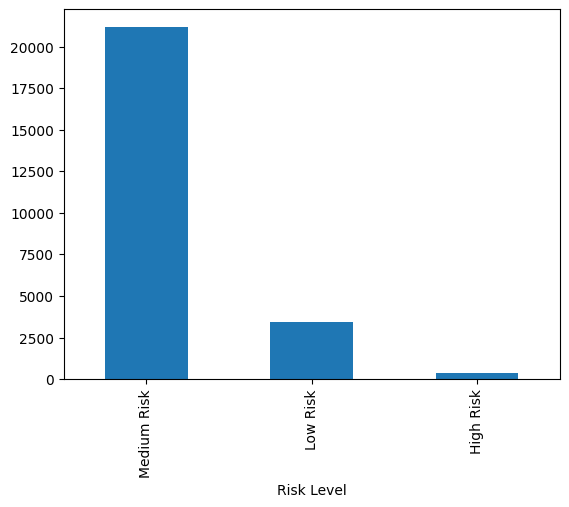

In [ ]:
# plot high risk for each risk level barplot count
high_risk_cases["Risk Level"].value_counts().plot(kind='bar')